Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from surprise import accuracy

In [2]:
movie_data = pd.read_csv('data/movies.csv')
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
tags = pd.read_csv('data/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
links = pd.read_csv('data/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


User ids are consistent between `ratings.csv` and `tags.csv` (i.e., the same id refers to the same user across the two files).

Movie ids are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv` (i.e., the same id refers to the same movie across these four data files).


In [6]:
movies_and_ratings = pd.merge(movie_data, ratings, on = 'movieId', how = 'left')
movies_and_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09


In [7]:
movies_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100854 non-null  int64  
 1   title      100854 non-null  object 
 2   genres     100854 non-null  object 
 3   userId     100836 non-null  float64
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.6+ MB


In [8]:
movies_and_ratings.isna().sum()

movieId       0
title         0
genres        0
userId       18
rating       18
timestamp    18
dtype: int64

In [9]:
# dropmissing values
movies_and_ratings = movies_and_ratings.dropna(subset = ['userId'])

In [10]:
movies_and_ratings.duplicated().sum()

0

In [11]:
movies_and_ratings.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [12]:
# drop unnecessary columns
movies_and_ratings = movies_and_ratings.drop(['timestamp'], axis=1)


## EDA

Find mean ratings for all the movies. A movie with all star rating average could be just because it was rated by one user.

In [13]:
movies_and_ratings.describe()

,movieId,userId,rating
count,100836.000000,100836.000000,100836.000000
mean,19435.295718,326.127564,3.501557
std,35530.987199,182.618491,1.042529
min,1.000000,1.000000,0.500000
25%,1199.000000,177.000000,3.000000
50%,2991.000000,325.000000,3.500000
75%,8122.000000,477.000000,4.000000
max,193609.000000,610.000000,5.000000


In [14]:
avg_ratings = movies_and_ratings.groupby(['movieId', 'title'])['rating'].mean()
avg_ratings

movieId  title                                    
1        Toy Story (1995)                             3.920930
2        Jumanji (1995)                               3.431818
3        Grumpier Old Men (1995)                      3.259615
4        Waiting to Exhale (1995)                     2.357143
5        Father of the Bride Part II (1995)           3.071429
                                                        ...   
193581   Black Butler: Book of the Atlantic (2017)    4.000000
193583   No Game No Life: Zero (2017)                 3.500000
193585   Flint (2017)                                 3.500000
193587   Bungo Stray Dogs: Dead Apple (2018)          3.500000
193609   Andrew Dice Clay: Dice Rules (1991)          4.000000
Name: rating, Length: 9724, dtype: float64

In [15]:
# Count of the movie ratings
movies_and_ratings.groupby(['movieId', 'title'])['rating'].count()

movieId  title                                    
1        Toy Story (1995)                             215
2        Jumanji (1995)                               110
3        Grumpier Old Men (1995)                       52
4        Waiting to Exhale (1995)                       7
5        Father of the Bride Part II (1995)            49
                                                     ... 
193581   Black Butler: Book of the Atlantic (2017)      1
193583   No Game No Life: Zero (2017)                   1
193585   Flint (2017)                                   1
193587   Bungo Stray Dogs: Dead Apple (2018)            1
193609   Andrew Dice Clay: Dice Rules (1991)            1
Name: rating, Length: 9724, dtype: int64

In [16]:
# convert to dataframe
ratings_new = pd.DataFrame(avg_ratings)
ratings_new

,,rating
movieId,title,
1,Toy Story (1995),3.920930
2,Jumanji (1995),3.431818
3,Grumpier Old Men (1995),3.259615
4,Waiting to Exhale (1995),2.357143
5,Father of the Bride Part II (1995),3.071429
...,...,...
193581,Black Butler: Book of the Atlantic (2017),4.000000
193583,No Game No Life: Zero (2017),3.500000
193585,Flint (2017),3.500000


In [17]:
ratings_new['num_of_ratings'] = pd.DataFrame(movies_and_ratings.groupby(['movieId', 'title'])['rating'].count())
ratings_new.head()

,,rating,num_of_ratings
movieId,title,,
1,Toy Story (1995),3.920930,215
2,Jumanji (1995),3.431818,110
3,Grumpier Old Men (1995),3.259615,52
4,Waiting to Exhale (1995),2.357143,7
5,Father of the Bride Part II (1995),3.071429,49


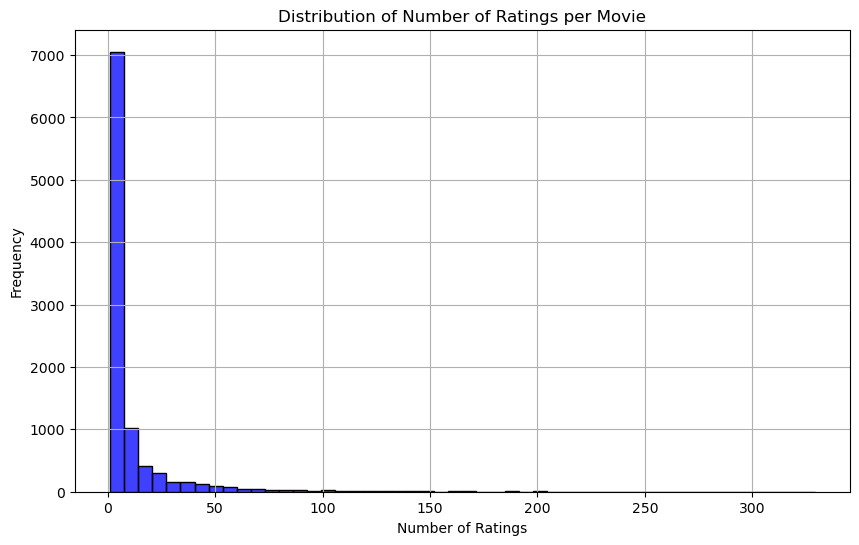

In [18]:

plt.figure(figsize=(10,6))
sns.histplot(x = ratings_new['num_of_ratings'], bins=50, kde=False, color='blue')
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


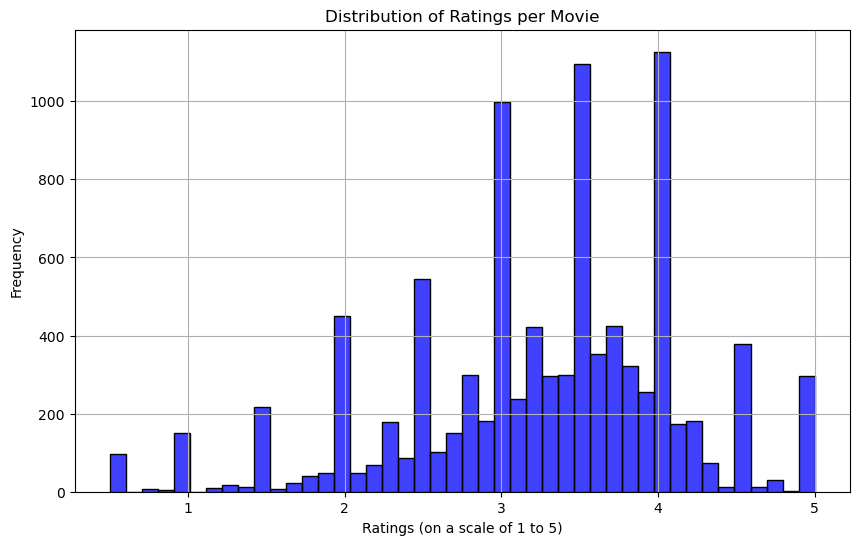

In [19]:

plt.figure(figsize=(10,6))
sns.histplot(x = ratings_new['rating'],  kde=False, color='blue')
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Ratings (on a scale of 1 to 5)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

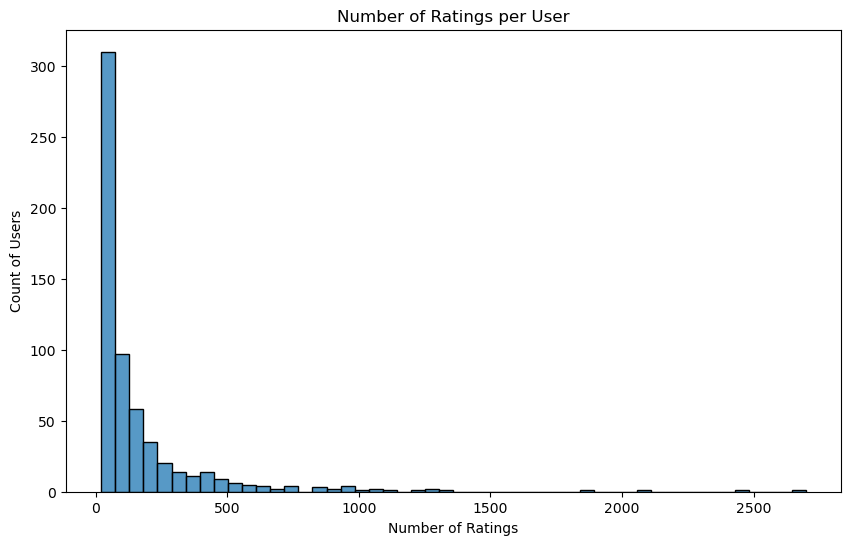

In [20]:
# calculate number of ratings per user
# Number of ratings per user
user_ratings_count = movies_and_ratings.groupby('userId').size()

plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()


In [21]:
# Sort by the number of ratings in descending order and get the top 10 most popular movies
most_popular_movies = ratings_new.sort_values(by='num_of_ratings', ascending=False).head(10)

# Display the most popular movies
print(most_popular_movies)



                                                     rating  num_of_ratings
movieId title                                                              
356     Forrest Gump (1994)                        4.164134             329
318     Shawshank Redemption, The (1994)           4.429022             317
296     Pulp Fiction (1994)                        4.197068             307
593     Silence of the Lambs, The (1991)           4.161290             279
2571    Matrix, The (1999)                         4.192446             278
260     Star Wars: Episode IV - A New Hope (1977)  4.231076             251
480     Jurassic Park (1993)                       3.750000             238
110     Braveheart (1995)                          4.031646             237
589     Terminator 2: Judgment Day (1991)          3.970982             224
527     Schindler's List (1993)                    4.225000             220


### Model 1 - baseline

In [22]:
# prepare data for 
reader = Reader(rating_scale = (0.5, 5.0))
data = Dataset.load_from_df(movies_and_ratings[['userId', 'movieId', 'rating']], reader)

# split data into train and test sets

train_set, test_set = train_test_split(data, test_size = 0.2)


In [23]:
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.similarities import cosine, msd, pearson
from surprise.model_selection import cross_validate

In [24]:
# using neighbourbased model
# deciding whether to use item-item Vs user-user similarity. Use whichever is fewer. In this case, users
print("Number of users: ", train_set.n_users, "\n")
print("Number of items: ", train_set.n_items, "\n")

Number of users:  610 

Number of items:  8990 



In [25]:
# define similarity metric to use 
similarity_cos = {"name": "cosine", "user_based": True}

# baseline model
baseline_model =KNNBasic(sim_options = similarity_cos)

# fit the model
baseline_model.fit(train_set)



Computing the cosine similarity matrix...
Done computing similarity matrix.


In [26]:
# baseline_model.sim


In [27]:
# make predictions
baseline_predictions = baseline_model.test(test_set)

In [28]:
print(accuracy.rmse(baseline_predictions))

RMSE: 0.9663
0.9662803479208472


This implies that the model is off by about 0.9 points for each guess it made for ratings. While it is not bad, there is room for improvement as we are working with a small scale (1 to 5)

### Model 2 - different similarity metric

In [29]:
similarity_pearson = {"name": "pearson", "user_based" : True}

# fit model
model_pearson = KNNBasic(sim_options = similarity_pearson)

model_pearson.fit(train_set)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [30]:
model_pearson_predictions = model_pearson.test(test_set)

In [31]:
# rmsse
accuracy.rmse(model_pearson_predictions)

RMSE: 0.9636


0.9635829222242408

The cosine similarity performed a little better than pearson

### Model 3 - KNNMeans

In [32]:
model_knn_means  = KNNWithMeans(sim_options = similarity_cos)

# fit model
model_knn_means.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
# make predictions
knn_means_predictions = model_knn_means.test(test_set)

In [34]:
# rmse
accuracy.rmse(knn_means_predictions) # we see an improvement in the rmse score (0.89)

RMSE: 0.8951


0.8950871683992417

### Model 4 - KNNBaseline

In [35]:
model_knn_baseline = KNNBaseline(sim_options=similarity_cos)

# fit model
model_knn_baseline.fit(train_set)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [36]:
knn_baseline_predictions = model_knn_baseline.test(test_set)

In [37]:
# rmse
accuracy.rmse(knn_baseline_predictions)

RMSE: 0.8727


0.872665657995939

### Model 5 - Model based 

In [38]:
# use SVD for collaborative filtering
model = SVD()
model.fit(train_set)

In [39]:
# Evaluate the model
predictions = model.test(test_set)
accuracy.rmse(predictions)

RMSE: 0.8673


0.8672858112329525

### Model 6 - Hyperparameter Tuning

In [40]:
from surprise.model_selection import GridSearchCV

In [41]:

param_grid= {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}

gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)


In [42]:
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.7s finished


In [43]:
gs_model.best_score['rmse']

0.8691793988684431